Sample code to acquire frames from the camera...

In [1]:
from matplotlib import pyplot as plt
import logging
from hamamatsu.dcam import copy_frame, dcam, Stream
%matplotlib qt

logging.basicConfig(level=logging.INFO)
with dcam:  # runs the __enter__() method, returns the object of class DCAM
    cam = dcam[0]    # camera object
    with cam:
        # print(cam.info)
        # print(cam['image_hsize'].value, cam['image_vsize'].value) # looks like a dictionary

        # Simple acquisition example
        nb_frames = 1
        cam["exposure_time"] = 0.01
        print(cam.camera_id)
        frame_list = [];
        frame_buffer_list=[]; print("Ready!!")
        with Stream(cam, nb_frames) as stream:
                logging.info("start acquisition")
                cam.start()
                print("Exposure time = ",cam["exposure_time"].value)
                for i, frame_buffer in enumerate(stream):
                    frame = copy_frame(frame_buffer)
                    frame_list.append(frame)
                    frame_buffer_list.append(frame_buffer)
                    # logging.info("acquired frame #%d/%d: %s", i+1, nb_frames, frame)
                    print(i)
                # logging.info("finished acquisition")
                print("finished acquisition")
plt.figure(); plt.imshow(frame,cmap='gray', vmin=0, vmax=62255);

In [3]:
type(cam)

hamamatsu.dcam.Device

In [2]:
import cv2 
 
im_gray = cv2.imread("1.jpg", cv2.IMREAD_GRAYSCALE)
im_color = cv2.applyColorMap(im_gray, cv2.COLORMAP_JET)
cv2.imshow("Image",im_color)
cv2.waitKey(0)

32

In [6]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def grab_frame(cap):
    ret,frame = cap.read()
    return cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

#Initiate the two cameras
cap1 = cv2.VideoCapture(0)
cap2 = cv2.VideoCapture(1)

#create two subplots
fig, ax = plt.figure()

#create two image plots
im1 = ax.imshow(grab_frame(cap1))

def update(i):
    im1.set_data(grab_frame(cap1))
    
ani = FuncAnimation(plt.gcf(), update, interval=1)
plt.show()

error: OpenCV(4.0.1) C:\ci\opencv-suite_1573470242804\work\modules\highgui\src\window.cpp:352: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [8]:
frame

SIMPLIFIED - Sample code breakdown..

In [ ]:
from matplotlib import pyplot as plt
import logging
from hamamatsu.dcam import *
logging.basicConfig(level=logging.INFO)
%matplotlib qt

dcam.__enter__()
cam = dcam[0]

In [ ]:
cam.open()
cam.capabilities == {}
# if not (cam.capabilities == {}):        # Camera initialize na hole 'cam.capabilities' empty thake.. tai ei check ta..
    # print("Go ahead !!")

In [ ]:
cam.close()

In [ ]:
# cam.open()
cam["exposure_time"] = 0.002
cam["trigger_source"] = 2
cam["trigger_mode"] = 6
nb_frames = 10
frame_list = []; frame_buffer_list=[]; print("Ready!!")
with Stream(cam, nb_frames) as stream:
    logging.info("start acquisition")
    cam.start()
    print("Exposure time [ms] = %0.2f",(cam["exposure_time"].value)*1e3)
    for i, frame_buffer in enumerate(stream):
        frame = copy_frame(frame_buffer)
        frame_list.append(frame)
        frame_buffer_list.append(frame_buffer)
        # logging.info("acquired frame #%d/%d: %s", i+1, nb_frames, frame)
    # logging.info("finished acquisition")
    print("finished acquisition")
plt.figure(); plt.imshow(frame,cmap='gray', vmin=0, vmax=2**16)
cam.close()

In [ ]:
cam.open()
if not (cam.capabilities == {}):
    print("\x1b[38;2;250;250;0mGO")
    print("Exposure time [ms] = %0.2f" % ((cam["exposure_time"].value)*1e3))
cam.close()

In [ ]:
type(frame_list)

In [ ]:

for i in range(len(frame_list)):
    plt.figure(); 
    plt.imshow(frame_list[i])

In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the resulting frame
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Sample PB sequence - use loop

In [ ]:
# Running the PB using the loop command
# Simulating the actual code for capturing using the camera
from spinapi import *

# define the variables
exp_time = 0.1 *ms
t_AOM = 10 *us
t_MW = 1000 *ns
t_total_seq = t_AOM + t_MW
N_repeat = round(exp_time / t_total_seq)
# N_repeat = 5
# PB connections
camera = 2**0
laser = 2**3
MW = 2**2

# program the pulse blaster
pb_init();
pb_get_version();
pb_core_clock(500);

pb_start_programming(PULSE_PROGRAM);

start =         pb_inst_pbonly(camera,  Inst.CONTINUE, 0, 100*ns)
loop_start =    pb_inst_pbonly(MW,      Inst.LOOP, N_repeat, t_MW)
loop_end =      pb_inst_pbonly(laser,   Inst.END_LOOP, loop_start, t_AOM)
seq_end =       pb_inst_pbonly(camera,  Inst.CONTINUE, 0, 100*ns)
seq_end =       pb_inst_pbonly(0,  Inst.BRANCH, start, 100*ns)
pb_stop_programming()
pb_close()


In [ ]:
pb_init(); pb_start(); pb_close()

In [ ]:
pb_init(); pb_stop(); pb_close()

The corrected PB code

In [ ]:
# the camera and the PB have different time units...
# PB base unit is ns, whereas camera base unit is seconds
# times are defined wrt PB (default)
# from spinapi import *     # spinapi cannot be imported w.o. the PB board
import numpy as np
ns=1; us=1e3; ms=1e6;
t_exposure = 300 *ms # 300 ms (let)
t_seq_total = 11 *us
t_cam_response = 38.96 *us      # the response time of the camera when the 'trigger' and the 'sequence' needs to run together..

N_trigger = np.floor(t_cam_response/t_seq_total)    # the fraction is rounded "down" so that the previous sequence runs for sometime and the remaining time is left empty... no sequence runs during that time..
N_total = np.floor(t_exposure/t_seq_total)
N_remaining = np.floor((t_exposure - 38.96*us)/t_seq_total)
print((N_trigger + N_remaining) <= N_total)
print(N_trigger)
print(N_remaining)
print(N_total)

t_seq_total = [11 *us, 9*us]

# below are two lists, with 2 elements each, one for signal and other for reference...
# the operation should use np.floor() and not np.rint().. think..
N_trigger = [int(np.floor(t_cam_response/element)) for element in t_seq_total]
N_remaining = [int(np.floor((t_exposure - t_cam_response)/element)) for element in t_seq_total]
N_total = [int(np.floor(t_exposure/element)) for element in t_seq_total]
# defining the buffer times (in nanoseconds) -  time when there will be no sequence running - quiet period    
t_buffer1 = (t_exposure - t_cam_response) - N_remaining[0]*t_seq_total[0]
t_buffer2 = t_cam_response - N_trigger[0]*t_seq_total[0]
t_buffer3 = (t_exposure - t_cam_response) - N_remaining[1]*t_seq_total[1]
t_buffer4 = t_cam_response - N_trigger[1]*t_seq_total[1]
t_buffer = [t_buffer1, t_buffer2, t_buffer3, t_buffer4]
print(N_trigger)
print(N_remaining)
print(N_total)

print(t_buffer)


'the_list' & instructionList breakdown...

In [9]:
# a sample 'the_list'
the_list = [[[[10, 0, 0, 100.0], [8, 0, 0, 190.0], [8, 6, 0, 80.0]], 0, [], [], {0: 0.0, 1: 0.01, 2: 1.3}],
     [[[8, 0, 0, 50.0], [2, 0, 0, 1290.0], [16, 6, 0, 8710.0]], 0, [], [], {0: 0.0, 1: 0.01, 2: 1.3}]]
instructionList = [];
for i in range(0, len(the_list)):   # len(the_list) = 2 (generally)... signal and reference...
    instructionList.append(the_list[i][0])

In [14]:
instructionList[1]

[[8, 0, 0, 50.0], [2, 0, 0, 1290.0], [16, 6, 0, 8710.0]]

Saving camera frames...
In what follows, we try to save the frames captured from the camera to a file. First simulate a variable that stores the data from the camera.

Generating camera frames

In [ ]:
# ekhane 'data_raw' ekta list with data from all the frames... save korte gele etake process kore arekta variable create korte hbe...
import numpy as np
from matplotlib import pyplot as plt
%matplotlib qt

hsize = 3; vsize = 5; n_frames = 4; N_scanpts = 6;
data_raw = [];
for j in range(0, N_scanpts):
    frames = np.zeros((hsize,vsize,n_frames));
    for i in range(0,n_frames):
        frame = np.random.rand(hsize, vsize)*2**16
        frame = frame.astype(int)
        frames[:,:,i] = frame       # numpy nd array
    data_raw.append(frames)       # 'data_raw' ekta list.. tar bhetore 'frames' (3d array).. each element of all_frames belong to a specific scan_pt
# for i in range(0,n_frames-1):
# frames[:,:,0] = np.concatenate(tuple(frames[:,:,i] for i in range(0,n_frames-1)), axis=1)
# how to process the data?? prepare the data such that there is minimum memory consumption
print(len(data_raw[0]))

In [ ]:
# ekhane 'data_raw' ekta numpy 2d-array... 'frames' ke 'flat' kore directly data_raw te store kora hochhe...
# sva ekorte extra processing lagbe na... plot korte gele process korte hbe..
import numpy as np
from matplotlib import pyplot as plt
%matplotlib qt

hsize = 3; vsize = 5; n_frames = 2; N_scanpts = 6;
data_raw = np.zeros((hsize*N_scanpts,vsize*n_frames));
for j in range(0, N_scanpts):
    frames = np.zeros((hsize,vsize,n_frames));
    for i in range(0,n_frames):
        frame = np.random.rand(hsize,vsize)*(2**16)
        frame = frame.astype(int)
        frames[:,:,i] = frame       # numpy nd array
    data_raw[j*hsize:(j+1)*hsize,:] = np.concatenate(tuple(frames[:,:,i] for i in range(0,n_frames)), axis=1)       # 2d-array
    
# for i in range(0,n_frames-1):
# frames[:,:,0] = np.concatenate(tuple(frames[:,:,i] for i in range(0,n_frames-1)), axis=1)
# how to process the data?? prepare the data such that there is minimum memory consumption
print(len(data_raw[0]))

In [ ]:
tuple(data_raw[0])

Defining the signal and reference for immediate plotting..

In [ ]:
# eta for the case where 'data_raw' is a list
# mean signal/reference ki sum naki average of the signal/reference frames ???
# (ALWAYS use numpy arrays instead of python lists for faster performance)
mean_sig = []; mean_ref = []
for j in range(0, N_scanpts):
    sum_of_signal_frames = []; sum_of_reference_frames = [];
    sum_of_signal_frames.append(np.array([np.sum(all_frames[0][:,:,i]) for i in range(0, n_frames,2)]))
    sum_of_reference_frames.append(np.array([np.sum(all_frames[0][:,:,i]) for i in range(1, n_frames,2)]))
    mean_sig.append(np.mean(sum_of_signal_frames))
    mean_ref.append(np.mean(sum_of_reference_frames))
# done...

In [ ]:
format = "%d\t"*10
format = (format[0:-1]+"\n")*5
print(format)

In [ ]:
# eta for the case when data_raw is a 2d-array
# need the frame info - hsize, vsize, n_frames
mean_sig = np.zeros(N_scanpts); mean_ref = np.zeros(N_scanpts);
for i in range(0,N_scanpts):
    # signal_frames = np.array([data_raw[i*vsize:(i+1)*vsize,j*hsize:(j+1)*hsize] for j in range(0,n_frames,2)])
    # reference_frames = np.array([data_raw[i*vsize:(i+1)*vsize,j*hsize:(j+1)*hsize] for j in range(1,n_frames,2)])
    sum_of_signal_frames = np.array([np.sum(data_raw[i*vsize:(i+1)*vsize,j*hsize:(j+1)*hsize]) for j in range(0,n_frames,2)])
    sum_of_reference_frames = np.array([np.sum(data_raw[i*vsize:(i+1)*vsize,j*hsize:(j+1)*hsize]) for j in range(1,n_frames,2)])

    mean_sig[i] = np.mean(sum_of_signal_frames)
    mean_ref[i] = np.mean(sum_of_reference_frames)

plt.plot(mean_sig); plt.plot(mean_ref); plt.legend(['Avg Sig', 'Avg Ref'])

Process the data for saving -- SAMPLE code

In [ ]:
# do this ONLY when the data is stored other than the intended saving format
# first signal and reference frames... a = all_frames[0]
# signal frame is a[:,:,0] and reference frame is a[:,:,1]
# then concat the two...
a = np.concatenate(tuple(all_frames[4][:,:,i] for i in range(0,n_frames)), axis=1)
a

Processing er command ta... (not required when the variable already stores in the intended manner)..

In [ ]:
# do the above for all the scan_pts, ie for all i in all_frames[i]
data_raw = np.concatenate(tuple(np.concatenate(tuple(all_frames[j][:,:,i] for i in range(0,n_frames)), axis=1) for j in range(0,N_scanpts)), axis=0)

# see that data_raw is a single nd array with (vsize*N_scanpts) rows and (2*hsize) columns... CHECK THIS FIRST AS TO WHAT SHOUD BE THE DIMENSION OF THE IMAGE.. RxC OR CxR ???

In [ ]:
len(data_raw)

Finally save the data to a file -- SAMPLE

In [ ]:
write_format = ""
for i in range(0, n_frames*vsize):
    write_format += "%d\t"
write_format = write_format[0:-1]+"\n"
# write_format

The write format..

In [ ]:
# puro file ta ek bar e likhte gele eta...
write_format = ""
for j in range(0,N_scanpts*hsize):
    for i in range(0, n_frames*vsize):
        write_format += "%d\t"
    write_format = write_format[0:-1]+"\n"
    # print(write_format)


In [ ]:
# file ta line by line likhte gele eta...
write_format = ""
for i in range(0, n_frames*vsize):
    write_format += "%d\t"
write_format = write_format[0:-1]+"\n"
# print(write_format)

Writing to file

In [ ]:
# puro file ta ek bar e lekha...
filename = "trial1.txt"
datafile = open(filename, 'a')
# for loop o kora jeto... kintu seta korle write_format ke paltate hoto.. per line info dite hoto..
# for line in data_raw:
    # datafile.write(write_format % tuple(line))
    # print(tuple(line))
# direct puro file ta write o kora jabe... w/o any loop.. use numpy.ravel().. returns a contiguous flattened array.
datafile.write(write_format % tuple(data_raw.ravel()))
datafile.close()

In [ ]:
tuple(data_raw.ravel())

In [ ]:
# file ta line by line lekha...
filename = "trial8.txt"
datafile = open(filename, 'a')
# for loop o kora jeto... kintu seta korle write_format ke paltate hoto.. per line info dite hoto..
for line in data_raw:
    datafile.write(write_format % tuple(line))
    # print(tuple(line))
# direct puro file ta write o kora jabe... w/o any loop.. use numpy.ravel().. returns a contiguous flattened array.
# datafile.write(write_format % tuple(data_raw.ravel()))
datafile.close()

In [ ]:
# scannedParam gulo save kora....
param = [i for i in range(0,10)]
param
tuple(i for i in param)


Plot a frame

In [ ]:
# for i in range(0,10):
plt.figure(); plt.imshow(all_frames[0][:,:,0],cmap='gray', vmin=0, vmax=2**16)


Koto time lagchhe??

In [ ]:
import time
import matplotlib.pyplot as plt
times = []
for i in range(0,100):
    start = time.perf_counter_ns()
    # put the statement here
    data_write_format = "%d\t" * 10*2048    # n_frames*hsize... na n_frames*vsize...
    # puro file ta ekbar e likhe debo... niche...
    data_write_format = (data_write_format[0:-1] + "\n") * (1000*2048) # remove \t at the end and add \n
    # file save korar ta sesh...
    stop = time.perf_counter_ns()
    times.append(stop-start)
plt.figure(); plt.hist(times); plt.xlabel("Times [ns]"); plt.ylabel("Occurence [arb]");

In [1]:
import Camcontrol as camctrl; import PBctrl_under_construc as PBctrl; import time; import numpy as np; import matplotlib.pyplot as plt
%matplotlib qt5

roi = [1076,1088,448,444]; Nsamples=2; cam = camctrl.open_camera();
instructionList = [[[0, 0, 0, 5000.0], [12, 6, 0, 20000.0]], [[0, 0, 0, 5000.0], [8, 6, 0, 20000.0]]]
t_exposure = 0.05; t_seq_total = [20000.0, 20000.0];
cam["exposure_time"] = t_exposure;
camctrl.set_roi(cam,roi,status=True);

hsize = roi[2]; vsize = roi[3]; 

frames=np.zeros((vsize,hsize,Nsamples),dtype=np.uint16);
time_taken = []

for i in range(0,1000):
    # print(i)
    stream = camctrl.ham.Stream(cam,Nsamples)   # the statement assigns the buffer according to the no of frames to acquire..
    stream.__enter__()
    start_time = time.perf_counter_ns()   # time in ns
    camctrl.cam.start()
    end_time = time.perf_counter_ns()   # time in ns
    # time.sleep(0.1)
    PBctrl.run_sequence_for_camera(instructionList, t_exposure*1e9, t_seq_total)
    for i, frame_buffer in enumerate(stream):
        frame = camctrl.ham.copy_frame(frame_buffer)
        frames[:,:,i] = frame
    stream.__exit__()
    PBctrl.pb_stop()
    # plt.figure(); plt.imshow(frames[:,:,1],vmin=0,vmax=2**16);
    time_taken.append((end_time-start_time)/1e6)    # time_taken in ms
plt.figure(); plt.hist(time_taken);

Camera Initialized..!


In [6]:
max(time_taken)

273.1735

In [2]:
plt.figure(); plt.hist(time_taken,500);

In [7]:
plt.title("Time taken by 'cam.start()' command (1000 trials)")

Text(0.5, 1.0, "Time taken by 'cam.start()' command (1000 trials)")

In [8]:
plt.xlabel('Time taken [ms]'); plt.ylabel('Occurences')

Text(46.972222222222214, 0.5, 'Occurences')

In [9]:
plt.xlim((260,280))

(260.0, 280.0)

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep  7 14:26:03 2021

@author: PC
"""
#%%
from spinapi import *
import time
import matplotlib.pyplot as plt
%matplotlib qt5

pb_init()
pb_get_version()
pb_core_clock(500)
ONE_PERIOD = 0x200000
# shortpulseFLAG = ONE_PERIOD

pb_start_programming(PULSE_PROGRAM)
on_time  = 500 *ms
off_time = 500 *ms
# start = pb_inst_pbonly(shortpulseFLAG^11, Inst.CONTINUE, 0, on_time)
start = pb_inst_pbonly(0b1000, Inst.CONTINUE,0,on_time)
pb_inst_pbonly(0b1000, Inst.BRANCH, start, off_time)
pb_stop_programming()

pb_reset()
pb_start()
time_taken=[]
for i in range(0,1000):
    start_time = time.perf_counter_ns()   # time in ns
    pb_stop()
    end_time = time.perf_counter_ns()   # time in ns
    time_taken.append((end_time-start_time)/1e3)  # time_taken in us
# print("Enter any key to stop")
# input("Enter any key to stop: ") 

# pb_stop()
pb_close()

#%% Reset the PB
pb_init(); pb_stop(); pb_close()
plt.figure(); plt.hist(time_taken,100);

In [7]:
time_taken

[6.6,
 3.6,
 3.4,
 3.4,
 3.4,
 3.4,
 3.4,
 3.4,
 3.4,
 3.4,
 3.4,
 3.4,
 3.3,
 3.3,
 3.4,
 3.4,
 3.3,
 3.4,
 3.3,
 3.4,
 3.4,
 3.3,
 3.3,
 3.4,
 3.3,
 3.4,
 3.7,
 3.7,
 3.6,
 3.6,
 3.4,
 3.4,
 3.4,
 3.4,
 3.3,
 3.4,
 3.4,
 3.6,
 3.5,
 3.4,
 3.5,
 3.3,
 3.7,
 3.3,
 3.3,
 6.7,
 3.4,
 3.8,
 3.7,
 3.6,
 3.4,
 3.4,
 3.4,
 3.8,
 3.4,
 3.5,
 3.4,
 3.5,
 3.4,
 3.4,
 3.4,
 3.5,
 3.5,
 3.4,
 4.1,
 3.6,
 3.6,
 3.4,
 3.6,
 3.3,
 3.3,
 3.5,
 3.4,
 3.3,
 3.4,
 3.4,
 3.4,
 3.4,
 3.4,
 3.5,
 3.3,
 3.8,
 3.4,
 3.4,
 3.6,
 3.6,
 3.6,
 3.6,
 3.6,
 3.5,
 3.3,
 3.5,
 3.4,
 3.4,
 3.6,
 3.4,
 3.5,
 3.7,
 3.4,
 3.4]

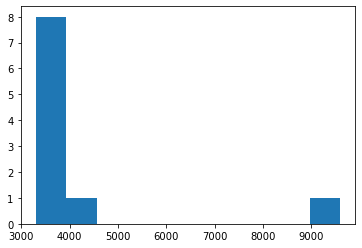

??

In [ ]:
np.concatenate(tuple(frames[:,:,j] for j in range(0,n_frames)),axis=1)

In [ ]:
np.array([np.sum(np.array([j, j+1, j+2])) for j in range(0,10)])

In [ ]:
[np.sum(data_raw[i*vsize:(i+1)*vsize,j*hsize:(j+1)*hsize]) for j in range(0,n_frames,2)]

In [ ]:
times

In [ ]:
param = [i for i in range(0,10)]
t_manip = np.array(param)
t_seq_total0 = 100 + t_manip
t_seq_total1 = 10 + t_manip
t_seq_total = np.transpose(np.array([t_seq_total0, t_seq_total1]))
t_seq_total

Using OpenCV for image processing

In [ ]:
import cv2
import numpy as np
# print(cv2.__version__)
import matplotlib.pyplot as plt
%matplotlib qt
img_path = "camera_image.txt"

img = np.loadtxt(img_path, delimiter="\t")
plt.imshow(img)


In [ ]:
cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
# cv2.resizeWindow("Image", shape[1], shape[0])
im = cv2.imshow("Image",frames)
cv2.applyColorMap(im, cv2.COLORMAP_JET)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
roi = cv2.selectROI(img)
plt.figure();
plt.subplot(121); plt.imshow(img); plt.Rectangle((roi[0],roi[1]),roi[2],roi[3])
plt.imshow(img); plt.gca().add_patch(plt.Rectangle((roi[0],roi[1]),roi[2],roi[3],edgecolor='r',facecolor='none'))
cropped = img[roi[1]:(roi[1]+roi[3]),roi[0]:(roi[0]+roi[2])]
plt.subplot(122); plt.imshow(cropped)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
plt.imshow(cropped[:,:,0])

cv2.selectROI()
origin of the plot is the top left corner
roi[0] and roi[1] = (x,y) of the top left corner of the selected ROI...
roi[2] = hsize
roi[3] = vsize

In [ ]:
img_raw.shape

In [ ]:
cv2.destroyAllWindows()

In [ ]:
camctrl.close_camera(cam)

In [ ]:
# save a frame ... write a method in camctrl.. for a single frame
path = "D:\\Brateen\\Python_codes\\qdSpectro-active\\Saved_Data\\2023-06-26\\"
filename = "camera_image_code.txt"
data=frame
[vsize, hsize] = data.shape
write_format = ""
for i in range(0, hsize):
    write_format += "%d\t"
write_format = write_format[0:-1] + "\n"
file = open(path+filename, 'w')
for line in data:
    file.write(write_format % tuple(line))
file.close()

In [ ]:
file.close()

In [ ]:
plt.imshow(frames)

In [ ]:
hsize

In [ ]:
# read a file
path = "D:\\Brateen\\Python_codes\\qdSpectro-active\\Saved_Data\\2023-06-26\\"
filename = "camera_image_code.txt"
original = np.loadtxt(path+filename, delimiter="\t")
shape = original.shape
plt.figure("hsize: %d, vsize: %d" % (shape[1], shape[0])); plt.imshow(original)

In [ ]:
import cv2
# print(cv2.__version__)
import matplotlib.pyplot as plt
%matplotlib qt
import Camcontrol as camctrl
import time
import numpy as np

cam = camctrl.open_camera()
cam["exposure_time"] = 0.10

In [ ]:
[frame, roi] = camctrl.select_roi(cam)
print(roi);
plt.figure(); plt.imshow(frame,cmap='gray',vmin=0,vmax=2**16);

In [ ]:
cam["subarray_mode"].value

In [ ]:
[frame, roi] = camctrl.select_roi(cam) # select an ROI
# print(roi);
# plt.figure(); plt.imshow(frame);    # display the full frame...

# roi = [0,900,300,1000]        # our ROI
roi = [int(element/4)*4 for element in roi];

# 'crop' the full frame to the given ROI
plt.figure("Cropped Image: "+str(roi));
plt.subplot(121); plt.imshow(frame,cmap='gray', vmin=0, vmax=2**16);    # here frame is full resolution
plt.gca().add_patch(plt.Rectangle((roi[0],roi[1]),roi[2],roi[3],edgecolor='r',facecolor='none'))
cropped = frame[roi[1]:(roi[1]+roi[3]),roi[0]:(roi[0]+roi[2])]
plt.subplot(122); plt.imshow(cropped,cmap='gray', vmin=0, vmax=2**16)

# now acquire the given ROI from camera
camctrl.set_roi(cam,roi,True)
frames = camctrl.get_frames(cam,roi)
print(frames.shape)
plt.figure("ROI from camera");
plt.subplot(121); plt.imshow(frame,cmap='gray', vmin=0, vmax=2**16);
plt.gca().add_patch(plt.Rectangle((roi[0],roi[1]),roi[2],roi[3],edgecolor='r',facecolor='none'))
# frames = np.transpose(frames,(1,0))
plt.subplot(122); plt.imshow(frames,cmap='gray', vmin=0, vmax=2**16)
plt.title("vsize: %d, hsize: %d" % ((frames.shape)[0], (frames.shape)[1]))

# cv2.namedWindow("Full Res Image (2048x2048)", cv2.WINDOW_NORMAL)
# for i in range(0,10):
# camctrl.live_view(cam)
    # cv2.imshow("Full Res Image (2048x2048)", frame)
    # cv2.waitKey(1)
    # time.sleep(1)
    # cv2.imshow("A", frame)
    # time.pause(0.001)


In [ ]:
roi = [0,0,1000,500]
# roi = camctrl.select_roi(cam)
roi = [int(element/4)*4 for element in roi];
camctrl.set_roi(cam,roi,True)
frames = camctrl.get_frames(cam,roi)
plt.figure(); plt.imshow(frames); plt.title("W: %d, H: %d" %(frames.shape))

In [ ]:
plt.figure(); plt.imshow(frames, vmin=0, vmax=2**16)
plt.colorbar()

In [ ]:
print(i) for i in range(0,2)]

Ki je hochhe "frames" er...????

In [ ]:
f1 = np.zeros(np.transpose(frames).shape)
print(f1)

In [ ]:
shape = frame.shape
shape

In [ ]:
shape = frame.shape
f1 = np.zeros((100,200))
f2 = np.zeros((100,200))
f3 = np.zeros((100,200))
for v in range(0,int(shape[0]/3)):
    f1[v,:] = frame[3*v,:]
    f2[v,:] = frame[3*v+1,:]
    f3[v,:] = frame[3*v+2,:]

In [ ]:
plt.figure(); plt.imshow(f3)

In [ ]:

roi = [1600,900,300,200]        # our ROI
roi = [int(element/4)*4 for element in roi];

# 'crop' the full frame to the given ROI
plt.figure("Cropped Image: "+str(roi));
plt.subplot(121); plt.imshow(original,cmap='gray', vmin=0, vmax=2**16);    # here frame is full resolution
plt.gca().add_patch(plt.Rectangle((roi[0],roi[1]),roi[2],roi[3],edgecolor='r',facecolor='none'))
cropped = original[roi[1]:(roi[1]+roi[3]),roi[0]:(roi[0]+roi[2])]
plt.subplot(122); plt.imshow(cropped)

In [ ]:
plt.figure(); plt.imshow(cropped)

In [ ]:
f1 = np.zeros(np.transpose(frames).shape)
shape=frames.shape
asp_ratio = shape[1]/shape[0] if shape[1]>shape[0] else shape[0]/shape[1]
print("f1: %d x %d" % f1.shape)
print("frames: %d x %d" % frames.shape)
for i in range(0,(frames.shape)[0],2):
    # print(i)
    f1[int(i/asp_ratio),:] = np.concatenate((frames[i,:], frames[i+1,:]))
plt.figure("Thik Image");plt.imshow(f1)
plt.figure("Baje Image");plt.imshow(frames)

In [ ]:
plt.imshow(frames)

In [ ]:
[frame, roi] = camctrl.select_roi(cam)
print(roi)
# display the cropped area
# cv2.namedWindow("Image", cv2.WINDOW_KEEPRATIO)
# cv2.imshow("Image", frame)
plt.figure();
plt.subplot(121); plt.imshow(frame); plt.gca().add_patch(plt.Rectangle((roi[0],roi[1]),roi[2],roi[3],edgecolor='r',facecolor='none'))
cropped = frame[roi[1]:(roi[1]+roi[3]),roi[0]:(roi[0]+roi[2])]
plt.subplot(122); plt.imshow(cropped)

In [ ]:
plt.figure();
plt.subplot(121); #plt.imshow(frame); plt.Rectangle((roi[0],roi[1]),roi[2],roi[3])
plt.imshow(frame); plt.gca().add_patch(plt.Rectangle((roi[0],roi[1]),roi[2],roi[3],edgecolor='r',facecolor='none'))
cropped = frame[roi[1]:(roi[1]+roi[3]),roi[0]:(roi[0]+roi[2])]
plt.subplot(122); plt.imshow(cropped)

In [ ]:
cv2.namedWindow("A", cv2.WINDOW_NORMAL)
cv2.imshow("A", frame)

In [ ]:
cv2.namedWindow("ROI", cv2.WINDOW_NORMAL) 
roi = cv2.select_roi(cam)

In [ ]:
roi

In [ ]:
plt.imshow(frame)

PyQt

In [ ]:
from PyQt5 import QtCore, QtGui, QtWidgets
import sys
 
class Ui_MainWindow(QtWidgets.QWidget):
    def setupUi(self, MainWindow):
        MainWindow.resize(422, 255)
        self.centralwidget = QtWidgets.QWidget(MainWindow)
 
        self.pushButton = QtWidgets.QPushButton(self.centralwidget)
        self.pushButton.setGeometry(QtCore.QRect(160, 130, 93, 28))
 
        # For displaying confirmation message along with user's info.
        self.label = QtWidgets.QLabel(self.centralwidget)   
        self.label.setGeometry(QtCore.QRect(170, 40, 201, 111))
 
        # Keeping the text of label empty initially.      
        self.label.setText("")    
 
        MainWindow.setCentralWidget(self.centralwidget)
        self.retranslateUi(MainWindow)
        QtCore.QMetaObject.connectSlotsByName(MainWindow)
 
    def retranslateUi(self, MainWindow):
        _translate = QtCore.QCoreApplication.translate
        MainWindow.setWindowTitle(_translate("MainWindow", "MainWindow"))
        self.pushButton.setText(_translate("MainWindow", "Proceed"))
        self.pushButton.clicked.connect(self.takeinputs)
         
    def takeinputs(self):
        # name, done1 = QtWidgets.QInputDialog.getText(
            #  self, 'Input Dialog', 'Enter your name:')
        # for i in range(0,10):
        roll, done2 = QtWidgets.QInputDialog.getInt(self, 'Input Dialog', 'Enter your roll:') 
        print(roll)
        # cgpa, done3 = QtWidgets.QInputDialog.getDouble(
            #   self, 'Input Dialog', 'Enter your CGPA:')
        
        # langs =['C', 'c++', 'Java', 'Python', 'Javascript']
        # lang, done4 = QtWidgets.QInputDialog.getItem(
        #   self, 'Input Dialog', 'Language you know:', langs)
 
        # if done1 and done2 and done3 and done4 :
        #      # Showing confirmation message along
        #      # with information provided by user.
        #      self.label.setText('Information stored Successfully\nName: '
        #                          +str(name)+'('+str(roll)+')'+'\n'+'CGPA: '
        #                          +str(cgpa)+'\nSelected Language: '+str(lang))  
  
        #      # Hide the pushbutton after inputs provided by the use.
        #      self.pushButton.hide()     
               
              
              
if __name__ == "__main__":
    app = QtWidgets.QApplication(sys.argv)
    MainWindow = QtWidgets.QMainWindow()
    ui = Ui_MainWindow()
    ui.setupUi(MainWindow)
    MainWindow.show()
 
    sys.exit(app.exec_())

In [ ]:
# another example code... cholei na...
import sys
from PyQt5.QtCore import *
from PyQt5.QtGui import *
from PyQt5.QtWidgets import *

class inputdialogdemo(QtWidgets):
   def __init__(self, parent = None):
      super(inputdialogdemo, self).__init__(parent)
		
      layout = QFormLayout()
      self.btn = QPushButton("Choose from list")
      self.btn.clicked.connect(self.getItem)
		
      self.le = QLineEdit()
      layout.addRow(self.btn,self.le)
      self.btn1 = QPushButton("get name")
      self.btn1.clicked.connect(self.gettext)
		
      self.le1 = QLineEdit()
      layout.addRow(self.btn1,self.le1)
      self.btn2 = QPushButton("Enter an integer")
      self.btn2.clicked.connect(self.getint)
		
      self.le2 = QLineEdit()
      layout.addRow(self.btn2,self.le2)
      self.setLayout(layout)
      self.setWindowTitle("Input Dialog demo")
		
   def getItem(self):
      items = ("C", "C++", "Java", "Python")
		
      item, ok = QInputDialog.getItem(self, "select input dialog", 
         "list of languages", items, 0, False)
			
      if ok and item:
         self.le.setText(item)
			
   def gettext(self):
      text, ok = QInputDialog.getText(self, 'Text Input Dialog', 'Enter your name:')
		
      if ok:
         self.le1.setText(str(text))
			
   def getint(self):
      num,ok = QInputDialog.getInt(self,"integer input dualog","enter a number")
		
      if ok:
         self.le2.setText(str(num))
			
def main(): 
   app = QApplication(sys.argv)
   ex = inputdialogdemo()
   ex.show()
   sys.exit(app.exec_())
	
if __name__ == '__main__':
   main()

Simulate interactive increase of exposure time

In [ ]:
from PyQt5 import QtCore, QtGui, QtWidgets
# import Camcontrol as camctrl
import sys
import cv2
import matplotlib.pyplot as plt
%matplotlib qt

# cam = camctrl.open_camera()
 
class Ui_MainWindow(QtWidgets.QWidget):
    def setupUi(self, MainWindow):
        MainWindow.resize(422, 255)
        self.centralwidget = QtWidgets.QWidget(MainWindow)
 
        self.pushButton = QtWidgets.QPushButton(self.centralwidget)
        self.pushButton.setGeometry(QtCore.QRect(160, 130, 93, 28))
 
        # For displaying confirmation message along with user's info.
        self.label = QtWidgets.QLabel(self.centralwidget)   
        self.label.setGeometry(QtCore.QRect(170, 40, 201, 111))
 
        # Keeping the text of label empty initially.      
        self.label.setText("")    
 
        MainWindow.setCentralWidget(self.centralwidget)
        self.retranslateUi(MainWindow)
        QtCore.QMetaObject.connectSlotsByName(MainWindow)
        
 
    def retranslateUi(self, MainWindow):
        _translate = QtCore.QCoreApplication.translate
        MainWindow.setWindowTitle(_translate("MainWindow", "MainWindow"))
        self.pushButton.setText(_translate("MainWindow", "Proceed"))
        self.pushButton.clicked.connect(self.takeinputs)

    def takeinputs(self):
        img = cv2.imread('1.jpg');
        cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
        cv2.imshow("Image",img);
        while True:
            # key = cv2.waitKey(1)
            time, done2 = QtWidgets.QInputDialog.getInt(self, 'Exposure', 'Enter a number:')
            if not done2:
                cv2.destroyAllWindows()
                # MainWindow.close()
                break
            # img = img-time
            cv2.imshow("Image",(img-time))
            # print(roll)

if __name__ == "__main__":
    app = QtWidgets.QApplication(sys.argv)
    MainWindow = QtWidgets.QMainWindow()
    ui = Ui_MainWindow()
    ui.setupUi(MainWindow)
    MainWindow.show()
    
    app.exec_()

In [ ]:
from PyQt5 import QtCore, QtGui, QtWidgets
import Camcontrol as camctrl
import sys
import cv2
import matplotlib.pyplot as plt
%matplotlib qt
plt.ion()

cam = camctrl.open_camera()
 
class Ui_MainWindow(QtWidgets.QWidget):
    def setupUi(self, MainWindow):
        MainWindow.resize(422, 255)
        self.centralwidget = QtWidgets.QWidget(MainWindow)
 
        self.pushButton = QtWidgets.QPushButton(self.centralwidget)
        self.pushButton.setGeometry(QtCore.QRect(160, 130, 93, 28))
 
        # For displaying confirmation message along with user's info.
        self.label = QtWidgets.QLabel(self.centralwidget)   
        self.label.setGeometry(QtCore.QRect(170, 40, 201, 111))
 
        # Keeping the text of label empty initially.      
        self.label.setText("")    
 
        MainWindow.setCentralWidget(self.centralwidget)
        self.retranslateUi(MainWindow)
        QtCore.QMetaObject.connectSlotsByName(MainWindow)
        
 
    def retranslateUi(self, MainWindow):
        _translate = QtCore.QCoreApplication.translate
        MainWindow.setWindowTitle(_translate("MainWindow", "MainWindow"))
        self.pushButton.setText(_translate("MainWindow", "Proceed"))
        self.pushButton.clicked.connect(self.takeinputs)

    def takeinputs(self):
        # inp = QtWidgets.QInputDialog(self)
        # cv2.namedWindow("Live: Hit 'Space' to exit", cv2.WINDOW_NORMAL)
        # frame = camctrl.get_frames(cam)
        # shape = frame.shape
        # cv2.resizeWindow("Image", int(shape[1]/4), int(shape[0]/4))
        # cv2.imshow("Live: Hit 'Space' to exit", frame)
        
        # exp_time=100      # in ms (initial value for widget)
        # while True:
        #     exp_time, done2 = inp.getInt(self, 'Exposure', 'Enter exposure time [ms]:',value=exp_time,min=1,max=10000)
        #     # self.close()
        #     if not done2:
        #         cv2.destroyAllWindows()
        #         # MainWindow.close()
        #         break
        #     cam["exposure_time"] = exp_time/1e3;
        #     frames = camctrl.get_frames(cam);
        #     shape = frames.shape
        #     for i in range(0,shape[2]):
        #         cv2.imshow("Live: Hit 'Space' to exit", frames[:,:,i])
        plt.figure("Set Exposure")
        exp_time=10;
        cam["exposure_time"] = exp_time/1e3;    # in ms (initial value for widget)
        frames = camctrl.get_frames(cam);        shape = frames.shape
        plt.imshow(frames,vmin=0,vmax=2**16); plt.colorbar()
        while True:
            exp_time, done2 = QtWidgets.QInputDialog.getInt(self, 'Exposure', 'Enter exposure time [ms]:',value=exp_time,min=1,max=10000)
            if not done2:
                plt.close("Set Exposure")
                break
            cam["exposure_time"] = exp_time/1e3;    # needs to be set in seconds, "exp_time" in ms
            frames = camctrl.get_frames(cam);
            # shape = frames.shape
            # for i in range(0,shape[2]):
            plt.imshow(frames,vmin=0,vmax=2**16)
            plt.pause(0.000001)
            # plt.show()
        app.quit()

if __name__ == "__main__":
    app = QtWidgets.QApplication(sys.argv)
    MainWindow = QtWidgets.QMainWindow()
    ui = Ui_MainWindow()
    ui.setupUi(MainWindow)
    MainWindow.show()
    
    app.exec_()

In [ ]:
import numpy as np
img = cv2.imread("1.jpg")
cv2.imshow("Image",img)
img-1
# img+1
# roi = cv2.selectROI("Image",img)

In [6]:
import numpy as np

data = np.genfromtxt("D:\\Brateen\\Python_codes\\qdSpectro-active\\Saved_Data\\2023-06-29\\Rabi_camera_3.txt",delimiter="\t",skip_header=1,max_rows=57536)
# param = 

In [8]:
data.shape

(13808641,)

In [6]:
a = [[1,2,3,4,5,6,0]]
a = a[0]
a

[1, 2, 3, 4, 5, 6, 0]

In [8]:
import matplotlib.pyplot as plt
%matplotlib qt5
plt.plot(a)

In [11]:
plt.title("Ajhfj", fontsize,10)

NameError: name 'fontsize' is not defined

In [7]:
def a():
    j=0;
    for i in range(0,int(1e7)):
        j+=1;
    return j
def make_rabi_seq():
    i=2
    return i


import time
import matplotlib.pyplot as plt
%matplotlib qt5

times = []
for i in range(0,10):
    start = time.perf_counter_ns()
    # put the statement here
    x = {'a':a, 'b':a}
    stop = time.perf_counter_ns()
    times.append(stop-start)
plt.figure(); plt.hist(times); plt.xlabel("Times [ns]"); plt.ylabel("Occurence [arb]");
print(x['a'])

<function a at 0x0000024F484B9670>


In [8]:
x

{'a': <function __main__.a()>, 'b': <function __main__.a()>}

In [6]:
the_list = [[[[28, 0, 0, 100.0], [12, 0, 0, 19800.0], [14, 0, 0, 100.0], [8, 0, 0, 19900.0], [10, 6, 0, 100.0]], 0, [], [], {0: 0.0, 1: 0.1, 2: 19.9, 3: 20.0, 4: 39.9}]]
instructionList = []
for i in range(0,len(the_list)):
    instructionList.append(the_list[i][0])
instructionList

[[[28, 0, 0, 100.0],
  [12, 0, 0, 19800.0],
  [14, 0, 0, 100.0],
  [8, 0, 0, 19900.0],
  [10, 6, 0, 100.0]]]

In [8]:
instructionList[0]

[[28, 0, 0, 100.0],
 [12, 0, 0, 19800.0],
 [14, 0, 0, 100.0],
 [8, 0, 0, 19900.0],
 [10, 6, 0, 100.0]]

In [98]:
import numpy as np
cts = [[i for i in range(0,10)], [i for i in range(100,110)]]     # cts for multi-channel acquisitions
# cts = [[99]] + cts
cts = np.ravel(np.array(cts))
# cts = np.insert(np.ravel(np.array(cts)),0,99)

In [99]:
cts = np.array((cts,cts,cts))
cts

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109],
       [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109],
       [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109]])

In [100]:
cts = np.insert(cts,0,[99,999,9999],axis=1)
cts

array([[  99,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         100,  101,  102,  103,  104,  105,  106,  107,  108,  109],
       [ 999,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         100,  101,  102,  103,  104,  105,  106,  107,  108,  109],
       [9999,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
         100,  101,  102,  103,  104,  105,  106,  107,  108,  109]])

In [97]:
cts

array([[ 99,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109],
       [ 99,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109],
       [ 99,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100, 101,
        102, 103, 104, 105, 106, 107, 108, 109]])

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109],
       [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109],
       [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109]])

In [82]:
cts[:,[i for i in range(0,20,2)]]


array([[  0,   2,   4,   6,   8, 100, 102, 104, 106, 108],
       [  0,   2,   4,   6,   8, 100, 102, 104, 106, 108],
       [  0,   2,   4,   6,   8, 100, 102, 104, 106, 108]])

In [84]:
signal = np.mean(cts[:,[i for i in range(0,20,2)]],axis=1)
reference = np.mean(cts[:,[i for i in range(1,20,2)]],axis=1)

In [88]:
contrast = np.divide(reference,signal)
contrast

array([1.01851852, 1.01851852, 1.01851852])

In [74]:
np.mean([i for i in range(0,10)])

4.5

In [115]:
a = [i for i in range(0,20)]
np.reshape(a,(2,10))


array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]])